In [1]:
from option import args
import torch
import utility
import data
import utils
import model
import loss
from trainer import Trainer
import os
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(args.seed)
ids = utils.get_ids()
# ids.sort()
total_vols = args.no_vols+args.test_vols
ids.sort()
ids = ids[:total_vols]
ids = np.random.choice(ids,total_vols,replace = False)
print(ids)

number of common Subjects  171
['104416' '102816' '146735' '134627' '134829' '164636' '131722' '157336'
 '156334' '155938' '167440' '148133' '135124' '130114' '146937' '146432'
 '158035' '164131' '105923' '137128' '125525' '115017' '162935' '144226'
 '145834' '159239' '132118' '130518' '140117' '109123' '146129' '118225'
 '111312' '165436' '102311' '128935' '100610' '126426' '108323' '115825'
 '114823' '111514' '116726' '167036' '158136']


In [2]:
args

Namespace(block_size=(32, 32, 4), var_blk_size=False, start_var=False, epochs=100, dir='/storage', batch_size=16, test_batch_size=8, sort=True, debug=False, preload=True, ret_points=False, enable_thres=True, thres=0.6, patience=3, patience_thres=0.5, no_vols=30, test_vols=15, lr=0.005, max_lr=0.01, lr_decay=18, decay_type='step', gamma=0.8, optimizer='ADAM', momentum=0.9, beta1=0.9, beta2=0.999, epsilon=1e-08, weight_decay=0, start_epoch=0, loss='1*MSE', skip_threshold=1000000.0, run_name='..', save='DTIArb', load='.', save_models=False, resume=0, print_every=20, save_every=30, cpu=False, gpu=0, seed=1, reset=False, pin_mem=False, model='dmri_rdn', encoder='rdb', tensor_val=False, attention=False, drop_prob=0, growth=32, model_type='3d', act='relu', pre_train='None', precision='single', cuda=True, scale=(1, 1, 1), offset=3, stable_epoch=1, tv_en=False)

In [3]:
logger = SummaryWriter('runs/'+ args.run_name)

checkpoint = utility.checkpoint(args)       ## setting the log and the train information
if checkpoint.ok:
    loader = data.Data(args,ids= ids)

Loading Done


In [4]:
model = model.Model(args)

Making model... here


In [5]:
lr,hr,scale = next(iter(loader.training_data))

lr_tensor = lr.squeeze().to('cuda').float()  # ranges from [0, 1]
hr_tensor = hr.squeeze().to('cuda').float()  # ranges from [0, 1]
scale = np.asarray(scale[0,:])
# lr = torch.permute(lr.squeeze(), (0,4,1,2,3))
# lr = np.asarray(lr)
# hr = np.asarray(hr).squeeze()
    


In [6]:
lr.shape,hr.shape,len(loader.training_data)

(torch.Size([1, 16, 32, 32, 4, 7]), torch.Size([1, 16, 32, 32, 4, 5]), 214)

In [34]:

if(len(lr_tensor.shape) == 5):
    lr = torch.permute(lr_tensor, (0,4,1,2,3))
else:
    lr = torch.permute(lr_tensor, (0,3,1,2))


# inference
model.eval()
pred = model.forward(lr,scale)

[32, 32, 4]


In [36]:
with torch.no_grad():
    pred = model.forward(lr,scale)

[32, 32, 4]


In [37]:
pred.shape

torch.Size([16, 5, 32, 32, 4])

In [38]:
len(pred[pred>1]),len(pred[pred==0])

(613, 0)

In [39]:
pred_plt = pred.cpu().detach()

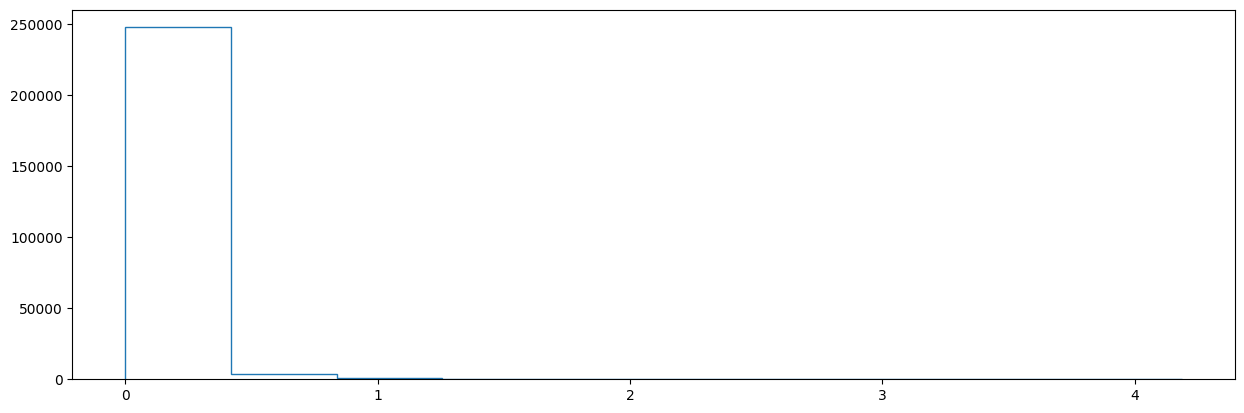

In [40]:
%matplotlib inline

fig,ax = plt.subplots(1,1)

# pbar = tqdm(total = len(loader.testing_data))
fig.set_figwidth(15)
c,b = np.histogram(pred_plt[pred_plt>0],10)
ax.stairs(c, b)

In [8]:
model

Model(
  (model): DMRI_RDN_3d(
    (encoder): RDN(
      (SFENet1): Conv3d(7, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (SFENet2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (RDBs): ModuleList(
        (0-4): 5 x RDB(
          (convs): Sequential(
            (0): RDB_Conv(
              (conv): Sequential(
                (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): ReLU()
              )
            )
            (1): RDB_Conv(
              (conv): Sequential(
                (0): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): ReLU()
              )
            )
            (2): RDB_Conv(
              (conv): Sequential(
                (0): Conv3d(96, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): ReLU()
              )
            )
            (3): RDB_Conv(
             

In [9]:
pred

tensor([[[[[ 1.1145e-01, -2.6278e-01, -1.2798e-01,  1.3141e-01],
           [ 1.7167e-01,  1.8404e-01,  1.3075e-01,  1.0508e-01],
           [ 1.4366e-01,  1.7643e-01, -9.4925e-02,  9.9109e-02],
           ...,
           [ 1.5391e-01,  2.1989e-01,  1.2043e-01,  1.1648e-01],
           [ 1.2892e-01,  1.6086e-01,  1.8339e-01,  1.3673e-01],
           [ 1.6482e-01,  1.7506e-01,  1.1646e-01,  1.1074e-01]],

          [[-1.6076e-03,  7.2457e-02,  1.5641e-01,  9.5107e-02],
           [ 1.6178e-01,  2.3712e-01,  2.1204e-01,  2.1112e-01],
           [ 2.3378e-01,  2.3870e-01,  3.5363e-01,  2.0558e-01],
           ...,
           [ 1.8791e-01,  2.1053e-01,  2.1390e-01,  1.9241e-01],
           [ 2.1772e-01,  1.8909e-01,  2.0586e-01,  8.9211e-02],
           [ 1.2679e-01,  1.5860e-01,  1.5397e-01,  1.0017e-01]],

          [[ 1.3800e-01,  3.5178e-02,  1.3859e-01,  1.3256e-01],
           [ 1.4583e-01,  1.6016e-01,  2.4596e-01,  1.1010e-01],
           [ 1.7285e-01,  1.9586e-01,  2.5638e-01,  1.